# <font color = purple> 2023 Synopsys ARC AIoT Design Contest - Analog Gauge Reader </font>

In [1]:
import os
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Activation, Softmax, ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Layer, Flatten, Dense, Dropout, add
from tensorflow.keras.utils import to_categorical

2023-07-19 12:22:41.851683: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## <font color = navy> GPU Setting </font>

In [2]:
!nvidia-smi

Wed Jul 19 12:22:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 31%   28C    P8     9W / 250W |      9MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:82:00.0 Off |                  N/A |
| 34%   

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')


2023-07-19 12:22:43.076576: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-07-19 12:22:43.112885: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-07-19 12:22:43.113443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2023-07-19 12:22:43.113970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:82:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBand

## <font color = navy> Configurations </font>

In [4]:
class Config():
    # Data path
    IMAGE_DIR = "./detection_img"
    LABEL_DIR = "./detection_label/detect_label.csv"
    
    # Degree unit
    DEG_UNIT = 5
    
    #  Dataloader parameters
    SPLIT = 0.2
    NUM_DATA = 5000
    
    # Batch size
    BATCH_SIZE = 4 #16
    
    # Image size
    IMG_HEIGHT = 150 #224
    IMG_WIDTH = 150 #224
    
    # Model parameters
    NUM_CLASSES = 10
    IN_CHANNEL = 1
    INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IN_CHANNEL)
    
    # Learning parameters
    lr = 1e-3
    num_epochs = 10 #20
    loss_func = "categorical_crossentropy"
    
    # Optimizer parameters
    opt = 'adam'
    wd = 10e-4
    
    # Models
    model_name1 = 'AlexNet'
    model_name2 = 'ResNet18'
    model_name3 = 'MobileNetV2-base'
    model_name4 = 'MobileNetV2-small'
    model_name5 = 'MobileNetV2-tiny'
    model_name6 = 'MobileNetV2-micro'
    model_name7 = 'MobileNetV2-nano'
    model_name8 = 'MobileNetV2-pico'

## <font color = navy> Load and Preprocess Dataset </font>

In [5]:
def load_data(img_path, lab_path, split=0.2):
    img_files = sorted(glob.glob(img_path + "/*"), key=os.path.getmtime) # Sort by time
    # img_files = glob.glob(img_path + "/*") (someting wrong)
    
    lab_df = pd.read_csv(lab_path)['detect'].to_numpy() # Read label from csv
    data_x = []
    data_y = []
    
    # Concatenate images & labels
    for idx, img_file in enumerate(img_files):
        # image
        img = Image.open(img_file)
        img = img.resize((Config.IMG_HEIGHT,Config.IMG_WIDTH))
        img = img.convert('L') # Convert to gray
        img = np.array(img, dtype=int)
        img = img - 128.0
        
        # label
        lab = np.array(lab_df[idx], dtype=int)
        lab = np.expand_dims(lab, axis=0)
        
        data_x.append(img)
        data_y.append(lab)
    
    # Number of data
    data_x = data_x[0:Config.NUM_DATA]
    data_y = data_y[0:Config.NUM_DATA]
    
    # Train & test split
    X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=split, random_state=42, shuffle=True)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, X_test, y_train, y_test

In [6]:
# Loading the dataset
X_train, X_test, y_train, y_test = load_data(Config.IMAGE_DIR, Config.LABEL_DIR)

In [7]:
print("Number of training data: ", len(X_train))
print("Number of testing data: ", len(X_test))

Number of training data:  4000
Number of testing data:  1000


## <font color = navy> Show Data </font>

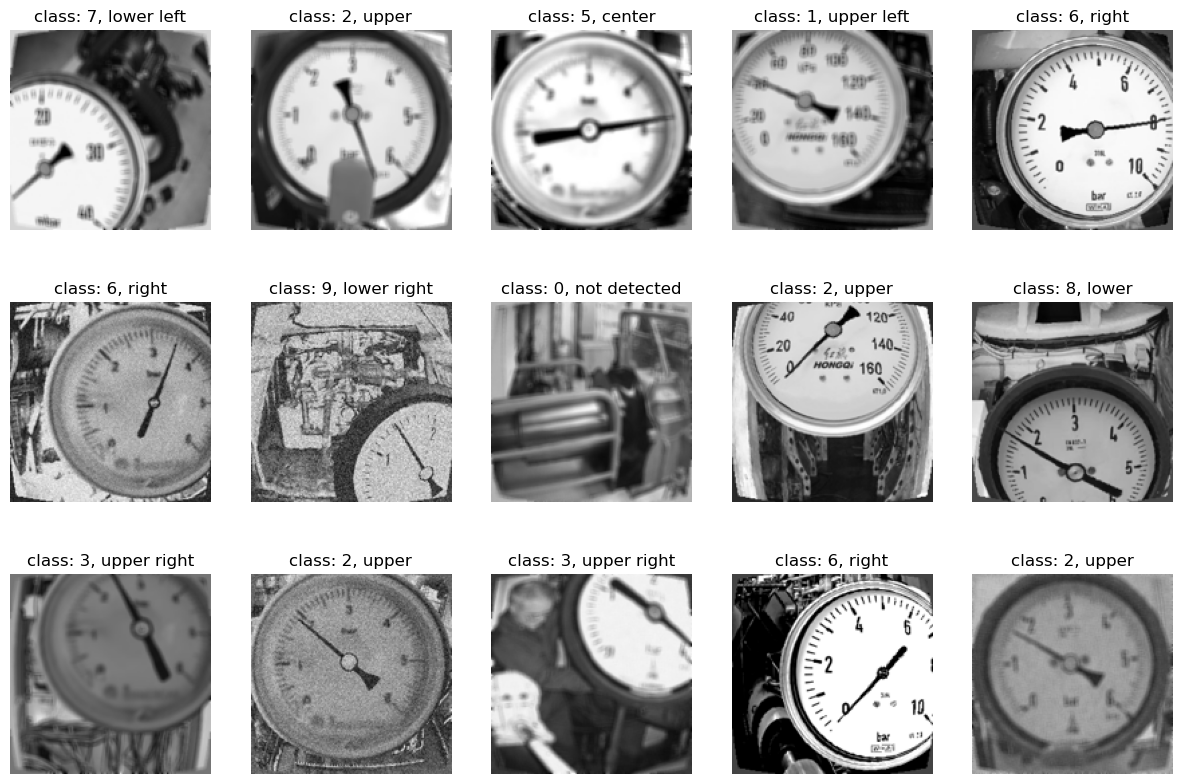

In [8]:
title_list = ['not detected',
              'upper left', 'upper', 'upper right',
              'left', 'center', 'right',
               'lower left', 'lower', 'lower right']

fig = plt.figure(figsize=(15,10))
for i in range(15):  
    ax = fig.add_subplot(3, 5, i+1)
    img = Image.fromarray(np.uint8(X_train[i] + 128))
    img = img.convert('RGBA')
    
    ax.imshow(img, cmap=plt.get_cmap('gray'))
    lab = np.squeeze(y_train[i])
    
        
    ax.set_title('class: {y}, {t}'.format(y=lab, t=title_list[lab]))
    
    plt.axis('off')

## <font color = navy> One-hot encoding </font>

In [9]:
y_train = to_categorical(y_train, Config.NUM_CLASSES)
y_test = to_categorical(y_test, Config.NUM_CLASSES)

In [10]:
print("y_train: \n", y_train)
print("\n")
print("y_test: \n", y_test)

y_train: 
 [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


y_test: 
 [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


## <font color = navy> Reshape Images </font>

In [11]:
# Reshape
X_train = X_train.reshape(-1, Config.IMG_HEIGHT, Config.IMG_WIDTH, 1)
X_test = X_test.reshape(-1, Config.IMG_HEIGHT, Config.IMG_WIDTH, 1)

-----

## <font color = navy> Build Model </font>

### <font color = red> Build Model 1: AlexNet </font>

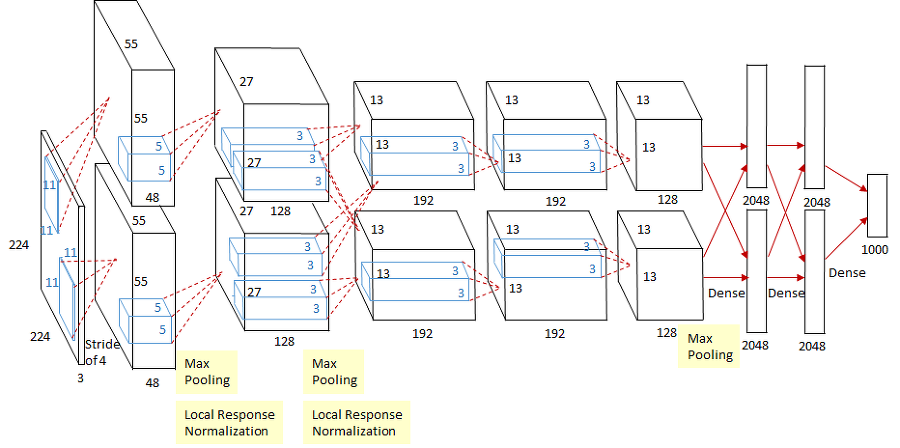

In [ ]:
model1 = Sequential()

# layer 1
model1.add(Conv2D(64, kernel_size=(7,7), activation='relu', input_shape=(Config.IMG_HEIGHT,Config.IMG_WIDTH,1)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# layer 2
model1.add(Conv2D(128, kernel_size=(5,5), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# layer 3
model1.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model1.add(BatchNormalization())

# layer 4
model1.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model1.add(BatchNormalization())

# layer 5
model1.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# layer 6
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

# layer 7
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

# layer 8
model1.add(Dense(Config.NUM_CLASSES, activation='softmax'))

In [ ]:
print('Model1: ', Config.model_name1)
model1.summary()

In [ ]:
print('Model1: ', Config.model_name1)
trainableParams1 = np.sum([np.prod(v.get_shape()) for v in model1.trainable_weights])
nonTrainableParams1 = np.sum([np.prod(v.get_shape()) for v in model1.non_trainable_weights])
totalParams1 = trainableParams1 + nonTrainableParams1

print('Trainable Prameters: ', trainableParams1)
print('Non-trainable Parameters: ', nonTrainableParams1)
print('Total Parameters: ', totalParams1)

----

### <font color = red> Build Model 2: ResNet18 </font>

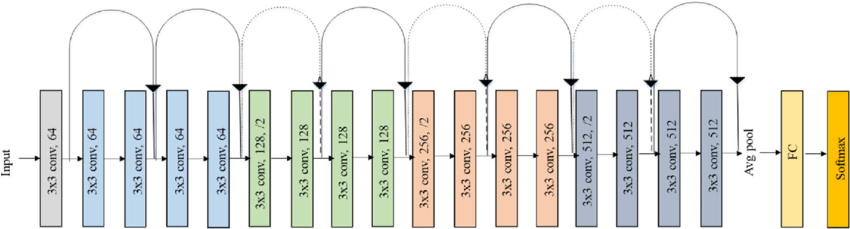

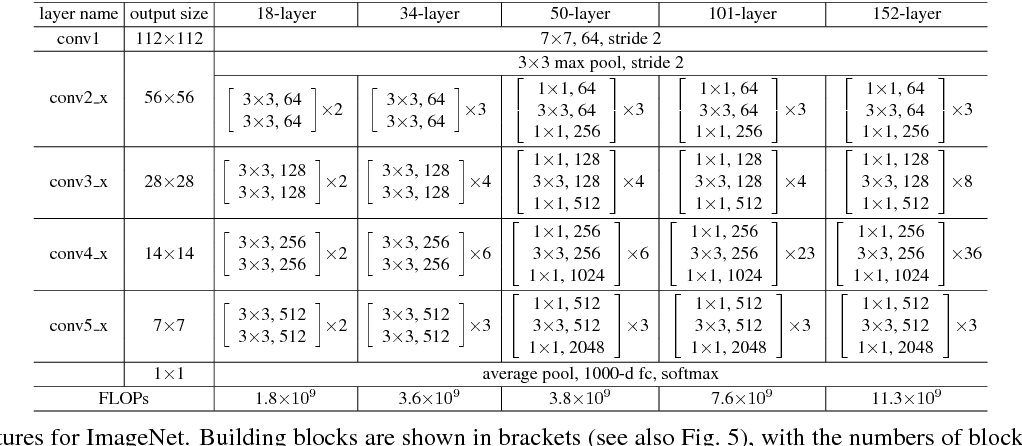

In [12]:
class BasicBlock(layers.Layer):
    def __init__(self, n_filter, stride=1):
        super(BasicBlock, self).__init__()

        # Block1
        self.conv1 = layers.Conv2D(n_filter, (3,3), strides=stride, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.Activation('relu')

        # Block2
        self.conv2 = layers.Conv2D(n_filter, (3,3), strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()

        if stride != 1:
            self.downsample = Sequential()
            self.downsample.add(layers.Conv2D(n_filter, (1,1), strides=stride))
        else:
            self.downsample = lambda x:x

    def call(self, inputs, training=None):
        identity = self.downsample(inputs)
        out = self.conv1(inputs)
        out = self.bn1(out, training=training)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out, training=training)

        out = layers.add([out, identity])
        out = tf.nn.relu(out)

        return out


class ResNet(keras.Model):
    def build_resblock(self, n_filter, blocks, stride=1):
        res_blocks = Sequential()
        res_blocks.add(BasicBlock(n_filter, stride))
        for _ in range(1, blocks):
            res_blocks.add(BasicBlock(n_filter, stride=1))

        return res_blocks

    def __init__(self, layer_dims, n_classes=Config.NUM_CLASSES):
        super(ResNet, self).__init__()

        self.stem = Sequential([
            layers.Conv2D(64, (3,3), strides=(1,1)),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPool2D(pool_size=(2,2), strides=(1,1), padding='same')
        ])

        self.layer1 = self.build_resblock(64, layer_dims[0])
        self.layer2 = self.build_resblock(128, layer_dims[1], stride=2)
        self.layer3 = self.build_resblock(256, layer_dims[2], stride=2)
        self.layer4 = self.build_resblock(512, layer_dims[3], stride=2)

        self.avgpool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(n_classes, 'softmax')

    def call(self, inputs, training=None):
        x = self.stem(inputs, training=training)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.fc(x)

        return x

In [13]:
def ResNet18():
    return ResNet([2, 2, 2, 2])

In [14]:
model2 = ResNet18()
model2.build(input_shape=(None, Config.IMG_HEIGHT, Config.IMG_WIDTH, Config.IN_CHANNEL))

2023-07-19 12:23:06.203396: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 12:23:06.807293: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-07-19 12:23:06.807553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2023-07-19 12:23:06.807779: I tensorflow/core/common_runtime/gpu/gpu_devi

In [ ]:
print('Model2: ', Config.model_name2)
model2.summary()

In [ ]:
print('Model2: ', Config.model_name2)
trainableParams2 = np.sum([np.prod(v.get_shape()) for v in model2.trainable_weights])
nonTrainableParams2 = np.sum([np.prod(v.get_shape()) for v in model2.non_trainable_weights])
totalParams2 = trainableParams2 + nonTrainableParams2

print('Trainable Prameters: ', trainableParams2)
print('Non-trainable Parameters: ', nonTrainableParams2)
print('Total Parameters: ', totalParams2)

----

### <font color = red> Build Model : MobileNetV2-base/small/tiny/micro/nano/pico </font>

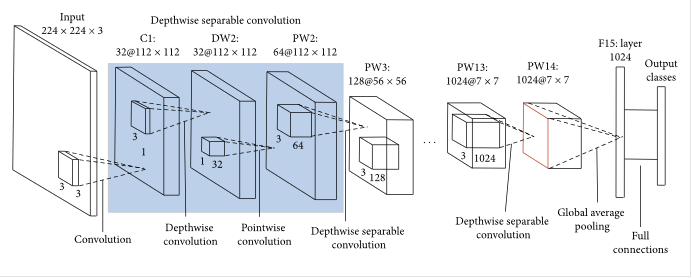

In [15]:
def expansion_block(x, t, filters, block_id):
    prefix = 'block_{}_'.format(block_id)
    total_filter = t*filters
    x = Conv2D(total_filter, 1, padding='same',use_bias=False, name=prefix+'expand')(x)
    x = BatchNormalization(name=prefix+'expand_bn')(x)
    x = ReLU(6, name=prefix+'expand_relu')(x) # ReLU 6
    
    return x

def depthwise_block(x, stride, block_id):
    prefix = 'block_{}_'.format(block_id)
    x = DepthwiseConv2D(3, strides=(stride,stride), padding='same', use_bias=False, name=prefix +'depthwise_conv')(x)
    x = BatchNormalization(name=prefix+'dw_bn')(x)
    x = ReLU(6,name=prefix+'dw_relu')(x)
    
    return x

def projection_block(x, out_channels, block_id):
    prefix = 'block_{}_'.format(block_id)
    x = Conv2D(filters=out_channels, kernel_size=1, padding='same', use_bias=False, name=prefix+'compress')(x)
    x = BatchNormalization(name=prefix+'compress_bn')(x)
    
    return x

In [16]:
def Bottleneck(x, t, filters, out_channels, stride, block_id):
    y = expansion_block(x, t, filters, block_id)
    y = depthwise_block(y, stride, block_id)
    y = projection_block(y, out_channels, block_id)
    
    if y.shape[-1]==x.shape[-1]:
        y = add([x,y])
    return y

In [17]:
def MobileNetV2(input_image=Config.INPUT_SHAPE, n_classes=Config.NUM_CLASSES, arch='base'):
    if arch == 'base':
        input = Input(input_image)

        x = Conv2D(32,kernel_size=3,strides=(2,2),padding = 'same', use_bias=False)(input)
        x = BatchNormalization(name='conv1_bn')(x)
        x = ReLU(6, name = 'conv1_relu')(x)

        # 17 Bottlenecks

        x = depthwise_block(x,stride=1,block_id=1)
        x = projection_block(x, out_channels=16,block_id=1)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 2,block_id = 2)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 3)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 2,block_id = 4)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 5)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 6)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 2,block_id = 7)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 8)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 9)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 10)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 11)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 12)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 13)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 2,block_id = 14)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 15)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 16)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 320, stride = 1,block_id = 17)


        #1*1 conv
        x = Conv2D(filters = 1280, kernel_size = 1, padding='same', use_bias=False, name = 'last_conv')(x)
        x = BatchNormalization(name='last_bn')(x)
        x = ReLU(6,name='last_relu')(x)

        #AvgPool 7*7
        x = GlobalAveragePooling2D(name='global_average_pool')(x)

        output = Dense(n_classes, activation='softmax')(x)

        model = Model(input, output)

        return model
    
    
    elif arch == 'small':
        input = Input(input_image)

        x = Conv2D(16,kernel_size=3,strides=(2,2),padding = 'same', use_bias=False)(input)
        x = BatchNormalization(name='conv1_bn')(x)
        x = ReLU(6, name = 'conv1_relu')(x)

        # 17 Bottlenecks

        x = depthwise_block(x,stride=1,block_id=1)
        x = projection_block(x, out_channels=8,block_id=1)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 2,block_id = 2)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 1,block_id = 3)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 16, stride = 2,block_id = 4)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 16, stride = 1,block_id = 5)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 16, stride = 1,block_id = 6)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 2,block_id = 7)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 8)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 9)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 10)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 48, stride = 1,block_id = 11)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 48, stride = 1,block_id = 12)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 48, stride = 1,block_id = 13)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 80, stride = 2,block_id = 14)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 80, stride = 1,block_id = 15)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 80, stride = 1,block_id = 16)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 17)


        #1*1 conv
        x = Conv2D(filters = 1280, kernel_size = 1, padding='same', use_bias=False, name = 'last_conv')(x)
        x = BatchNormalization(name='last_bn')(x)
        x = ReLU(6,name='last_relu')(x)

        #AvgPool 7*7
        x = GlobalAveragePooling2D(name='global_average_pool')(x)

        output = Dense(n_classes, activation='softmax')(x)

        model = Model(input, output)

        return model
    
    
    elif arch == 'tiny':
        input = Input(input_image)

        x = Conv2D(8,kernel_size=3,strides=(2,2),padding = 'same', use_bias=False)(input)
        x = BatchNormalization(name='conv1_bn')(x)
        x = ReLU(6, name = 'conv1_relu')(x)

        # 17 Bottlenecks

        x = depthwise_block(x,stride=1,block_id=1)
        x = projection_block(x, out_channels=4,block_id=1)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 6, stride = 2,block_id = 2)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 6, stride = 1,block_id = 3)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 2,block_id = 4)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 5)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 6)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 16, stride = 2,block_id = 7)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 16, stride = 1,block_id = 8)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 16, stride = 1,block_id = 9)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 16, stride = 1,block_id = 10)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 11)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 12)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 13)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 40, stride = 2,block_id = 14)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 40, stride = 1,block_id = 15)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 40, stride = 1,block_id = 16)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 80, stride = 1,block_id = 17)


        #1*1 conv
        x = Conv2D(filters = 1280, kernel_size = 1, padding='same', use_bias=False, name = 'last_conv')(x)
        x = BatchNormalization(name='last_bn')(x)
        x = ReLU(6,name='last_relu')(x)

        #AvgPool 7*7
        x = GlobalAveragePooling2D(name='global_average_pool')(x)

        output = Dense(n_classes, activation='softmax')(x)

        model = Model(input, output)

        return model
    
    
    elif arch == 'micro':
        input = Input(input_image)

        x = Conv2D(4,kernel_size=3,strides=(2,2),padding = 'same', use_bias=False)(input)
        x = BatchNormalization(name='conv1_bn')(x)
        x = ReLU(6, name = 'conv1_relu')(x)

        # 17 Bottlenecks

        x = depthwise_block(x,stride=1,block_id=1)
        x = projection_block(x, out_channels=4,block_id=1)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 3, stride = 2,block_id = 2)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 3, stride = 1,block_id = 3)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 4, stride = 2,block_id = 4)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 4, stride = 1,block_id = 5)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 4, stride = 1,block_id = 6)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 2,block_id = 7)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 8)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 9)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 10)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 1,block_id = 11)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 1,block_id = 12)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 1,block_id = 13)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 20, stride = 2,block_id = 14)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 20, stride = 1,block_id = 15)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 20, stride = 1,block_id = 16)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 40, stride = 1,block_id = 17)


        #1*1 conv
        x = Conv2D(filters = 1280, kernel_size = 1, padding='same', use_bias=False, name = 'last_conv')(x)
        x = BatchNormalization(name='last_bn')(x)
        x = ReLU(6,name='last_relu')(x)

        #AvgPool 7*7
        x = GlobalAveragePooling2D(name='global_average_pool')(x)

        output = Dense(n_classes, activation='softmax')(x)

        model = Model(input, output)

        return model
    
    
    
    elif arch == 'nano':
        input = Input(input_image)

        x = Conv2D(4,kernel_size=3,strides=(2,2),padding = 'same', use_bias=False)(input)
        x = BatchNormalization(name='conv1_bn')(x)
        x = ReLU(6, name = 'conv1_relu')(x)

        # 17 Bottlenecks

        x = depthwise_block(x,stride=1,block_id=1)
        x = projection_block(x, out_channels=4,block_id=1)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 3, stride = 2,block_id = 2)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 3, stride = 1,block_id = 3)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 4, stride = 2,block_id = 4)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 4, stride = 1,block_id = 5)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 4, stride = 1,block_id = 6)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 2,block_id = 7)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 8)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 9)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 10)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 1,block_id = 11)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 1,block_id = 12)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 1,block_id = 13)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 20, stride = 2,block_id = 14)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 20, stride = 1,block_id = 15)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 20, stride = 1,block_id = 16)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 40, stride = 1,block_id = 17)


        #1*1 conv
        x = Conv2D(filters = 640, kernel_size = 1, padding='same', use_bias=False, name = 'last_conv')(x) #640
        x = BatchNormalization(name='last_bn')(x)
        x = ReLU(6,name='last_relu')(x)

        #AvgPool 7*7
        x = GlobalAveragePooling2D(name='global_average_pool')(x)

        output = Dense(n_classes, activation='softmax')(x)

        model = Model(input, output)

        return model
    
    
    elif arch == 'pico':
        input = Input(input_image)

        x = Conv2D(4,kernel_size=3,strides=(2,2),padding = 'same', use_bias=False)(input)
        x = BatchNormalization(name='conv1_bn')(x)
        x = ReLU(6, name = 'conv1_relu')(x)

        # 17 Bottlenecks

        x = depthwise_block(x,stride=1,block_id=1)
        x = projection_block(x, out_channels=4,block_id=1)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 3, stride = 2,block_id = 2)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 3, stride = 1,block_id = 3)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 4, stride = 2,block_id = 4)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 4, stride = 1,block_id = 5)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 4, stride = 1,block_id = 6)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 2,block_id = 7)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 8)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 9)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 8, stride = 1,block_id = 10)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 1,block_id = 11)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 1,block_id = 12)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 12, stride = 1,block_id = 13)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 20, stride = 2,block_id = 14)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 20, stride = 1,block_id = 15)
        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 20, stride = 1,block_id = 16)

        x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 40, stride = 1,block_id = 17)


        #1*1 conv
        x = Conv2D(filters = 64, kernel_size = 1, padding='same', use_bias=False, name = 'last_conv')(x) #640 #256
        x = BatchNormalization(name='last_bn')(x)
        x = ReLU(6,name='last_relu')(x)

        #AvgPool 7*7
        x = GlobalAveragePooling2D(name='global_average_pool')(x)

        output = Dense(n_classes, activation='softmax')(x)

        model = Model(input, output)

        return model

### <font color = red> Build Model 3: MobileNetV2-base</font>

In [18]:
model3 = MobileNetV2(arch='base')

In [19]:
print('Model3: ', Config.model_name3)
model3.summary()

Model3:  MobileNetV2-base
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 75, 75, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 32)   128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 75, 75, 32)   0           conv1_bn[0][0]                   
____________________________________________________________________

In [20]:
print('Model3: ', Config.model_name3)
trainableParams3 = np.sum([np.prod(v.get_shape()) for v in model3.trainable_weights])
nonTrainableParams3 = np.sum([np.prod(v.get_shape()) for v in model3.non_trainable_weights])
totalParams3 = trainableParams3 + nonTrainableParams3

print('Trainable Prameters: ', trainableParams3)
print('Non-trainable Parameters: ', nonTrainableParams3)
print('Total Parameters: ', totalParams3)

Model3:  MobileNetV2-base
Trainable Prameters:  2236106
Non-trainable Parameters:  34112
Total Parameters:  2270218


----

### <font color = red> Build Model 4: MobileNetV2-small </font>

In [21]:
model4 = MobileNetV2(arch='small')

In [22]:
print('Model4: ', Config.model_name4)
model4.summary()

Model4:  MobileNetV2-small
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 75, 75, 16)   144         input_2[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 16)   64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 75, 75, 16)   0           conv1_bn[0][0]                   
_________________________________________________________________

In [23]:
print('Model4: ', Config.model_name4)
trainableParams4 = np.sum([np.prod(v.get_shape()) for v in model4.trainable_weights])
nonTrainableParams4 = np.sum([np.prod(v.get_shape()) for v in model4.non_trainable_weights])
totalParams4 = trainableParams4 + nonTrainableParams4

print('Trainable Prameters: ', trainableParams4)
print('Non-trainable Parameters: ', nonTrainableParams4)
print('Total Parameters: ', totalParams4)

Model4:  MobileNetV2-small
Trainable Prameters:  696970
Non-trainable Parameters:  18336
Total Parameters:  715306


---

### <font color = red> Build Model 5: MobileNetV2-tiny </font>

In [24]:
model5 = MobileNetV2(arch='tiny')

In [25]:
print('Model5: ', Config.model_name5)
model5.summary()

Model5:  MobileNetV2-tiny
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 75, 75, 8)    72          input_3[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 8)    32          conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 75, 75, 8)    0           conv1_bn[0][0]                   
__________________________________________________________________

In [26]:
print('Model5: ', Config.model_name5)
trainableParams5 = np.sum([np.prod(v.get_shape()) for v in model5.trainable_weights])
nonTrainableParams5 = np.sum([np.prod(v.get_shape()) for v in model5.non_trainable_weights])
totalParams5 = trainableParams5 + nonTrainableParams5

print('Trainable Prameters: ', trainableParams5)
print('Non-trainable Parameters: ', nonTrainableParams5)
print('Total Parameters: ', totalParams5)

Model5:  MobileNetV2-tiny
Trainable Prameters:  248978
Non-trainable Parameters:  10448
Total Parameters:  259426


### <font color = red> Build Model 6: MobileNetV2-micro </font>

In [27]:
model6 = MobileNetV2(arch='micro')

In [28]:
print('Model6: ', Config.model_name6)
model6.summary()

Model6:  MobileNetV2-micro
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 75, 75, 4)    36          input_4[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 4)    16          conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 75, 75, 4)    0           conv1_bn[0][0]                   
_________________________________________________________________

In [29]:
print('Model6: ', Config.model_name6)
trainableParams6 = np.sum([np.prod(v.get_shape()) for v in model6.trainable_weights])
nonTrainableParams6 = np.sum([np.prod(v.get_shape()) for v in model6.non_trainable_weights])
totalParams6 = trainableParams6 + nonTrainableParams6

print('Trainable Prameters: ', trainableParams6)
print('Non-trainable Parameters: ', nonTrainableParams6)
print('Total Parameters: ', totalParams6)

Model6:  MobileNetV2-micro
Trainable Prameters:  105652
Non-trainable Parameters:  6556
Total Parameters:  112208


### <font color = red> Build Model 7: MobileNetV2-nano </font>

In [30]:
model7 = MobileNetV2(arch='nano')

In [31]:
print('Model7: ', Config.model_name7)
model7.summary()

Model7:  MobileNetV2-nano
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 75, 75, 4)    36          input_5[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 4)    16          conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 75, 75, 4)    0           conv1_bn[0][0]                   
__________________________________________________________________

In [32]:
print('Model7: ', Config.model_name7)
trainableParams7 = np.sum([np.prod(v.get_shape()) for v in model7.trainable_weights])
nonTrainableParams7 = np.sum([np.prod(v.get_shape()) for v in model7.non_trainable_weights])
totalParams7 = trainableParams7 + nonTrainableParams7

print('Trainable Prameters: ', trainableParams7)
print('Non-trainable Parameters: ', nonTrainableParams7)
print('Total Parameters: ', totalParams7)

Model7:  MobileNetV2-nano
Trainable Prameters:  72372
Non-trainable Parameters:  5276
Total Parameters:  77648


### <font color = red> Build Model 8: MobileNetV2-pico </font>

In [33]:
model8 = MobileNetV2(arch='pico')

In [34]:
print('Model8: ', Config.model_name8)
model8.summary()

Model8:  MobileNetV2-pico
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 75, 75, 4)    36          input_6[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 4)    16          conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 75, 75, 4)    0           conv1_bn[0][0]                   
__________________________________________________________________

In [35]:
print('Model8: ', Config.model_name8)
trainableParams8 = np.sum([np.prod(v.get_shape()) for v in model8.trainable_weights])
nonTrainableParams8 = np.sum([np.prod(v.get_shape()) for v in model8.non_trainable_weights])
totalParams8 = trainableParams8 + nonTrainableParams8

print('Trainable Prameters: ', trainableParams8)
print('Non-trainable Parameters: ', nonTrainableParams8)
print('Total Parameters: ', totalParams8)

Model8:  MobileNetV2-pico
Trainable Prameters:  42420
Non-trainable Parameters:  4124
Total Parameters:  46544


----

## <font color = navy> Train Model </font>

### <font color = red> Train Model 1: AlexNet </font>

In [36]:
# Compile model
model1.compile(optimizer=Config.opt,
              loss=Config.loss_func,
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

# Set training
history1 = model1.fit(X_train, y_train,
          validation_split=0.2,
          batch_size=Config.BATCH_SIZE,
          verbose=1,
          epochs=Config.num_epochs
          )

NameError: name 'model1' is not defined

### <font color = red> Train Model 2: ResNet18 </font>

In [37]:
# Compile model
model2.compile(optimizer=Config.opt,
              loss=Config.loss_func,
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

# Set training
history2 = model2.fit(X_train, y_train,
          validation_split=0.2,
          batch_size=Config.BATCH_SIZE,
          verbose=1,
          epochs=Config.num_epochs
          )

2023-07-19 12:23:17.455257: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-19 12:23:17.474934: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999990000 Hz


Epoch 1/10


2023-07-19 12:23:19.142862: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-07-19 12:23:20.095553: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8700
2023-07-19 12:23:20.755035: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-19 12:23:20.755083: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2023-07-19 12:23:20.756278: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-19 12:23:20.756445: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-07-19 12:23:20.780254: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

 17/800 [..............................] - ETA: 31s - loss: 4.4992 - accuracy: 0.1029 - top_k_categorical_accuracy: 0.1618

KeyboardInterrupt: 

### <font color = red> Train Model 3: MobileNetV2-base </font>

In [38]:
# Compile model
model3.compile(optimizer=Config.opt,
              loss=Config.loss_func,
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

# Set training
history3 = model3.fit(X_train, y_train,
          validation_split=0.2,
          batch_size=Config.BATCH_SIZE,
          verbose=1,
          epochs=Config.num_epochs
          )

Epoch 1/10
800/800 [==============================] - 48s 56ms/step - loss: 1.4853 - accuracy: 0.4975 - top_k_categorical_accuracy: 0.6944 - val_loss: 1.2982 - val_accuracy: 0.6062 - val_top_k_categorical_accuracy: 0.8000
Epoch 2/10
800/800 [==============================] - 43s 54ms/step - loss: 0.8078 - accuracy: 0.7506 - top_k_categorical_accuracy: 0.8994 - val_loss: 0.6427 - val_accuracy: 0.7725 - val_top_k_categorical_accuracy: 0.9150
Epoch 3/10
800/800 [==============================] - 41s 52ms/step - loss: 0.5850 - accuracy: 0.8303 - top_k_categorical_accuracy: 0.9378 - val_loss: 0.5056 - val_accuracy: 0.8737 - val_top_k_categorical_accuracy: 0.9413
Epoch 4/10
800/800 [==============================] - 42s 53ms/step - loss: 0.5139 - accuracy: 0.8516 - top_k_categorical_accuracy: 0.9469 - val_loss: 0.3630 - val_accuracy: 0.9125 - val_top_k_categorical_accuracy: 0.9650
Epoch 5/10
800/800 [==============================] - 43s 53ms/step - loss: 0.4327 - accuracy: 0.8838 - top_k_ca

### <font color = red> Train Model 4: MobileNetV2-small </font>

In [39]:
model4.compile(optimizer=Config.opt,
              loss=Config.loss_func,
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

# Set training
history4 = model4.fit(X_train, y_train,
          validation_split=0.2,
          batch_size=Config.BATCH_SIZE,
          verbose=1,
          epochs=Config.num_epochs
          )

Epoch 1/10
800/800 [==============================] - 44s 49ms/step - loss: 1.9566 - accuracy: 0.3194 - top_k_categorical_accuracy: 0.5122 - val_loss: 1.2302 - val_accuracy: 0.6100 - val_top_k_categorical_accuracy: 0.8250
Epoch 2/10
800/800 [==============================] - 40s 50ms/step - loss: 1.0110 - accuracy: 0.6628 - top_k_categorical_accuracy: 0.8522 - val_loss: 0.5880 - val_accuracy: 0.8300 - val_top_k_categorical_accuracy: 0.9388
Epoch 3/10
800/800 [==============================] - 39s 48ms/step - loss: 0.7006 - accuracy: 0.7778 - top_k_categorical_accuracy: 0.9169 - val_loss: 0.6812 - val_accuracy: 0.8438 - val_top_k_categorical_accuracy: 0.9413
Epoch 4/10
800/800 [==============================] - 40s 50ms/step - loss: 0.5760 - accuracy: 0.8359 - top_k_categorical_accuracy: 0.9413 - val_loss: 0.4451 - val_accuracy: 0.8763 - val_top_k_categorical_accuracy: 0.9600
Epoch 5/10
800/800 [==============================] - 40s 50ms/step - loss: 0.4814 - accuracy: 0.8569 - top_k_ca

KeyboardInterrupt: 

### <font color = red> Train Model 5: MobileNetV2-tiny </font>

In [ ]:
model5.compile(optimizer=Config.opt,
              loss=Config.loss_func,
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

# Set training
history5 = model5.fit(X_train, y_train,
          validation_split=0.2,
          batch_size=Config.BATCH_SIZE,
          verbose=1,
          epochs=Config.num_epochs
          )

### <font color = red> Train Model 6: MobileNetV2-micro </font>

In [ ]:
model6.compile(optimizer=Config.opt,
              loss=Config.loss_func,
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

# Set training
history6 = model6.fit(X_train, y_train,
          validation_split=0.2,
          batch_size=Config.BATCH_SIZE,
          verbose=1,
          epochs=Config.num_epochs
          )

### <font color = red> Train Model 7: MobileNetV2-nano </font>

In [ ]:
model7.compile(optimizer=Config.opt,
              loss=Config.loss_func,
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

# Set training
history7 = model7.fit(X_train, y_train,
          validation_split=0.2,
          batch_size=Config.BATCH_SIZE,
          verbose=1,
          epochs=Config.num_epochs
          )

### <font color = red> Train Model 8: MobileNetV2-pico </font>

In [ ]:
model8.compile(optimizer=Config.opt,
              loss=Config.loss_func,
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

# Set training
history8 = model8.fit(X_train, y_train,
          validation_split=0.2,
          batch_size=Config.BATCH_SIZE,
          verbose=1,
          epochs=Config.num_epochs
          )

---

## <font color = navy> Plot Learning Curve </font>

### <font color = red> Plot Model1: AlexNet </font>

In [ ]:
# Accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy (AlexNet)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss (AlexNet)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### <font color = red> Plot Model 2: ResNet18 </font>

In [ ]:
# Accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy (ResNet18)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss (ResNet18)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### <font color = red> Plot Model 3: MobileNetV2-base </font>

In [ ]:
# Accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy (MobileNetV2-base)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss (MobileNetV2-base)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### <font color = red> Plot Model 4: MobileNetV2-small </font>

In [ ]:
# Accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy (MobileNetV2-small)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss (MobileNetV2-small)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### <font color = red> Plot Model 5: MobileNetV2-tiny</font>

In [ ]:
# Accuracy
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy (MobileNetV2-tiny)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss (MobileNetV2-tiny)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### <font color = red> Plot Model 6: MobileNetV2-micro </font>

In [ ]:
# Accuracy
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('model accuracy (MobileNetV2-micro)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Loss
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('model loss (MobileNetV2-micro)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### <font color = red> Plot Model 7: MobileNetV2-nano </font>

In [ ]:
# Accuracy
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('model accuracy (MobileNetV2-nano)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Loss
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('model loss (MobileNetV2-nano)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### <font color = red> Plot Model 8: MobileNetV2-pico </font>

In [ ]:
# Accuracy
plt.plot(history8.history['accuracy'])
plt.plot(history8.history['val_accuracy'])
plt.title('model accuracy (MobileNetV2-pico)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Loss
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('model loss (MobileNetV2-pico)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color = navy> Evaluation </font>

### <font color = red> Evaluation Model 1: AlexNet </font>

In [ ]:
# Model Evaluation
inference_start = time.time()

score1 = model1.evaluate(X_test, y_test, verbose = 0)

inference_end = time.time()

inference_time1 = (inference_end - inference_start) / len(X_test)

print('test loss: ', score1[0])
print('top-1 accuracy: ', score1[1])
print('top-k accuracy: ', score1[2])
print('inference time: ', inference_time1)

### <font color = red> Evaluation Model 2: ResNet18 </font>

In [ ]:
# Model Evaluation
inference_start = time.time()

score2 = model2.evaluate(X_test, y_test, verbose = 0)

inference_end = time.time()

inference_time2 = (inference_end - inference_start) / len(X_test)

print('test loss: ', score2[0])
print('top-1 accuracy: ', score2[1])
print('top-k accuracy: ', score2[2])
print('inference time: ', inference_time2)

### <font color = red> Evaluation Model 3: MobileNetV2-base </font>

In [ ]:
# Model Evaluation
inference_start = time.time()

score3 = model3.evaluate(X_test, y_test, verbose = 0)

inference_end = time.time()

inference_time3 = (inference_end - inference_start) / len(X_test)

print('test loss: ', score3[0])
print('top-1 accuracy: ', score3[1])
print('top-k accuracy: ', score3[2])
print('inference time: ', inference_time3)

### <font color = red> Evaluation Model 4: MobileNetV2-small </font>

In [ ]:
# Model Evaluation
inference_start = time.time()

score4 = model4.evaluate(X_test, y_test, verbose = 0)

inference_end = time.time()

inference_time4 = (inference_end - inference_start) / len(X_test)

print('test loss: ', score4[0])
print('top-1 accuracy: ', score4[1])
print('top-k accuracy: ', score4[2])
print('inference time: ', inference_time4)

### <font color = red> Evaluation Model 5: MobileNetV2-tiny </font>

In [ ]:
# Model Evaluation
inference_start = time.time()

score5 = model5.evaluate(X_test, y_test, verbose = 0)

inference_end = time.time()

inference_time5 = (inference_end - inference_start) / len(X_test)

print('test loss: ', score5[0])
print('top-1 accuracy: ', score5[1])
print('top-k accuracy: ', score5[2])
print('inference time: ', inference_time5)

### <font color = red> Evaluation Model 6: MobileNetV2-micro </font>

In [ ]:
# Model Evaluation
inference_start = time.time()

score6 = model6.evaluate(X_test, y_test, verbose = 0)

inference_end = time.time()

inference_time6 = (inference_end - inference_start) / len(X_test)

print('test loss: ', score6[0])
print('top-1 accuracy: ', score6[1])
print('top-k accuracy: ', score6[2])
print('inference time: ', inference_time6)

### <font color = red> Evaluation Model 7: MobileNetV2-nano </font>

In [ ]:
# Model Evaluation
inference_start = time.time()

score7 = model7.evaluate(X_test, y_test, verbose = 0)

inference_end = time.time()

inference_time7 = (inference_end - inference_start) / len(X_test)

print('test loss: ', score7[0])
print('top-1 accuracy: ', score7[1])
print('top-k accuracy: ', score7[2])
print('inference time: ', inference_time7)

### <font color = red> Evaluation Model 8: MobileNetV2-pico </font>

In [ ]:
# Model Evaluation
inference_start = time.time()

score8 = model8.evaluate(X_test, y_test, verbose = 0)

inference_end = time.time()

inference_time8 = (inference_end - inference_start) / len(X_test)

print('test loss: ', score8[0])
print('top-1 accuracy: ', score8[1])
print('top-k accuracy: ', score8[2])
print('inference time: ', inference_time8)

## <font color = navy> Comparison </font>

In [ ]:
test_acc1 = score1[1]
recip_time1 = 1 / inference_time1
num_params1 = totalParams1

print("Test Accuracy: ", test_acc1)
print("Reciprocal of Inference Time: ", recip_time1)
print("Total Parameters: ", num_params1)

In [ ]:
test_acc2 = score2[1]
recip_time2 = 1 / inference_time2
num_params2 = totalParams2

print("Test Accuracy: ", test_acc2)
print("Reciprocal of Inference Time: ", recip_time2)
print("Total Parameters: ", num_params2)

In [ ]:
test_acc3 = score3[1]
recip_time3 = 1 / inference_time3
num_params3 = totalParams3

print("Test Accuracy: ", test_acc3)
print("Reciprocal of Inference Time: ", recip_time3)
print("Total Parameters: ", num_params3)

In [ ]:
test_acc4 = score4[1]
recip_time4 = 1 / inference_time4
num_params4 = totalParams4

print("Test Accuracy: ", test_acc4)
print("Reciprocal of Inference Time: ", recip_time4)
print("Total Parameters: ", num_params4)

In [ ]:
test_acc5 = score5[1]
recip_time5 = 1 / inference_time5
num_params5 = totalParams5

print("Test Accuracy: ", test_acc5)
print("Reciprocal of Inference Time: ", recip_time5)
print("Total Parameters: ", num_params5)

In [ ]:
test_acc6 = score6[1]
recip_time6 = 1 / inference_time6
num_params6 = totalParams6

print("Test Accuracy: ", test_acc6)
print("Reciprocal of Inference Time: ", recip_time6)
print("Total Parameters: ", num_params6)

In [ ]:
test_acc7 = score7[1]
recip_time7 = 1 / inference_time7
num_params7 = totalParams7

print("Test Accuracy: ", test_acc7)
print("Reciprocal of Inference Time: ", recip_time7)
print("Total Parameters: ", num_params7)

In [ ]:
test_acc8 = score8[1]
recip_time8 = 1 / inference_time8
num_params8 = totalParams8

print("Test Accuracy: ", test_acc8)
print("Reciprocal of Inference Time: ", recip_time8)
print("Total Parameters: ", num_params8)

In [ ]:
param_unit = 10e6
dot_scaling = 8*10e4
display_left = -0.02


plt.figure(figsize=(8,6))

plt.ylim(1, 0)
plt.ylim(0, 2000)


plt.scatter(test_acc1,
            recip_time1,
            c='b',
            s=num_params1/dot_scaling,
            label=str(Config.model_name1)
            )

plt.scatter(test_acc2,
            recip_time2,
            c='green',
            s=num_params2/dot_scaling,
            label=str(Config.model_name2)
            )

plt.scatter(test_acc3,
            recip_time3,
            c='orange',
            s=num_params3/dot_scaling,
            label=str(Config.model_name3)
            )

plt.scatter(test_acc4,
            recip_time4,
            c='indigo',
            s=num_params4/dot_scaling,
            label=str(Config.model_name4)
            )

plt.scatter(test_acc5,
            recip_time5,
            c='darkorchid',
            s=num_params5/dot_scaling,
            label=str(Config.model_name5)
            )

plt.scatter(test_acc6,
            recip_time6,
            c='mediumorchid',
            s=num_params6/dot_scaling,
            label=str(Config.model_name6)
            )

plt.legend(scatterpoints=1, markerscale=1, loc='upper left')
plt.grid('on')
plt.title('Analog Gauge Reader - Degree Classification', fontsize=18)
plt.xlabel('Top-1 Accuracy', fontsize=16)
plt.ylabel('FPS', fontsize=16)



plt.annotate(str(Config.model_name1) + "\n #Params: " + str(format(num_params1/param_unit, '.2f')) + ' M',
             (test_acc1, recip_time1 - 150), fontsize=10)

plt.annotate(str(Config.model_name2) + "\n #Params: " + str(format(num_params2/param_unit, '.2f')) + ' M',
             (test_acc2, recip_time2), fontsize=10)

plt.annotate(str(Config.model_name3) + "\n #Params: " + str(format(num_params3/param_unit, '.2f')) + ' M',
             (test_acc3, recip_time3 + 20), fontsize=10)

plt.annotate(str(Config.model_name4) + "\n #Params: " + str(format(num_params4/param_unit, '.2f')) + ' M',
             (test_acc4, recip_time4 + 20), fontsize=10)

plt.annotate(str(Config.model_name5) + "\n #Params: " + str(format(num_params5/param_unit, '.2f')) + ' M',
             (test_acc5, recip_time5 - 120), fontsize=10)

plt.annotate(str(Config.model_name6) + "\n #Params: " + str(format(num_params6/param_unit, '.2f')) + ' M',
             (test_acc6, recip_time6), fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
param_unit = 10e6
dot_scaling = 8*10e4
display_left = -0.02


# plt.figure(figsize=(8,6))

# plt.ylim(1, 0)
# plt.ylim(0, 10e6)




plt.scatter(test_acc3,
            1/num_params3,
            c='red',
            label=str(Config.model_name3)
            )

plt.scatter(test_acc4,
            1/num_params4,
            c='orangered',
            label=str(Config.model_name4)
            )

plt.scatter(test_acc5,
            1/num_params5,
            c='darkorange',
            label=str(Config.model_name5)
            )

plt.scatter(test_acc6,
            1/num_params6,
            c='orange',
            label=str(Config.model_name6)
            )



plt.legend(scatterpoints=1, markerscale=1, loc='lower left')
plt.grid('on')
plt.title('Analog Gauge Reader - Degree Classification', fontsize=16)
plt.xlabel('Top-1 Accuracy', fontsize=14)
plt.ylabel('1/Number of Parameters', fontsize=14)




plt.annotate(str(Config.model_name3) + "\n #Params: " + str(format(num_params3/param_unit, '.2f')) + ' M',
             (test_acc3 - 0.017, 1/num_params3), fontsize=10)

plt.annotate(str(Config.model_name4) + "\n #Params: " + str(format(num_params4/param_unit, '.2f')) + ' M',
             (test_acc4, 1/num_params4), fontsize=10)

plt.annotate(str(Config.model_name5) + "\n #Params: " + str(format(num_params5/param_unit, '.2f')) + ' M',
             (test_acc5, 1/num_params5), fontsize=10)

plt.annotate(str(Config.model_name6) + "\n #Params: " + str(format(num_params6/param_unit, '.2f')) + ' M',
             (test_acc6, 1/num_params6 - 0.06*10e-6), fontsize=10)

plt.tight_layout()
plt.show()

## <font color = navy> Choose Model </font>

In [ ]:
model = model8

## <font color = navy> Save Model </font>

In [ ]:
# Save model and weights of this model
model.save('model_save_pico150_detector_v2')

## <font color = navy> Load Model </font>

In [ ]:
# lOAD model and weights of this model
model_2 = keras.models.load_model('model_save_pico150_detector_v2')

# Model Evaluation
score = model_2.evaluate(X_test, y_test, verbose = 0)
print('test loss', score[0])
print('top-1 accuracy', score[1])
print('top-k accuracy', score[2])

In [ ]:
predictions = model.predict(X_test)

In [ ]:
print("Test Prediction (Probability): ")
print(predictions)

In [ ]:
y_label = np.argmax(y_test, axis=-1)
y_pred = np.argmax(predictions, axis=-1)

In [ ]:
print("Test Predictions (class):")
print(y_pred)

In [ ]:
fig = plt.figure(figsize=(15,10))
for i in range(15):  
    ax = fig.add_subplot(3, 5, i+1)
    img = Image.fromarray(np.uint8(np.squeeze(X_test[i]) + 128)) # *255
    img = img.convert('RGBA')
    
    ax.imshow(img, cmap=plt.get_cmap('gray'))
    lab = np.squeeze(y_pred[i])
    lower = lab * Config.DEG_UNIT
    upper = (lab+1) * Config.DEG_UNIT
    
    # ax.set_title('class: {y}'.format(y=np.squeeze(y_train[i])))
    ax.set_title('label: {y1}, pred: {y2}'.format(y1=np.squeeze(y_label[i]), y2=np.squeeze(y_pred[i])))
    # ax.set_title('degree: {y1}~{y2}'.format(y1=lower, y2=upper))
    plt.axis('off')

## <font color = navy> Tolerance Level </font>

In [ ]:
correct_pn0 = 0 # Top-1 Accuracy
correct_pn1 = 0 # tolerance for positive and negative one category
correct_pn2 = 0 # tolerance for positive and negative two category

for i in range(len(y_label)):  
    lab = np.squeeze(y_label[i])
    pred = np.squeeze(y_pred[i])
    
    if pred == lab:
        correct_pn0 +=1
    
    if pred >= (Config.NUM_CLASSES + lab - 1) % Config.NUM_CLASSES or pred <= (Config.NUM_CLASSES + lab + 1) % Config.NUM_CLASSES:
        correct_pn1 += 1
    
    if pred >= (Config.NUM_CLASSES + lab - 2) % Config.NUM_CLASSES or pred <= (Config.NUM_CLASSES + lab + 2) % Config.NUM_CLASSES:
        correct_pn2 += 1
    
acc_pn0 = correct_pn0 / len(y_label)
acc_pn1 = correct_pn1 / len(y_label)
acc_pn2 = correct_pn2 / len(y_label)

In [ ]:
acc_pn0

In [ ]:
acc_pn1

In [ ]:
acc_pn2

## <font color = navy> Convert model into TFLM format </font>

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

In [ ]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_test).batch(1).take(100):
        yield [tf.cast(input_value, tf.float32)]

converter.representative_dataset = representative_data_gen


quantized_model = converter.convert()

# Save the quantized model
with open('model_pico150_detector_quantized_v2.tflite', 'wb') as f:
    f.write(quantized_model)

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='model_pico150_detector_quantized_v2.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

In [ ]:
print('X_test Shape: ', X_test.shape)
print('y_test Shape: ', y_test.shape)

In [ ]:
# Get the input scale and zero point
input_scale, input_zero_point = input_details[0]['quantization']
print(input_scale, input_zero_point)
    
# Test the model on all input data.
inputs, test_labels = X_test, y_test

In [ ]:
correct_predictions = 0
predictions = [] 

start_time = time.time()
for i in tqdm(range(len(inputs))):
    # Quantize the input data
    input_data = np.expand_dims(inputs[i], axis=0)
    input_data = np.int8(input_data)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run the inference
    interpreter.invoke()

    # Dequantize the output data
    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_scale, output_zero_point = output_details[0]['quantization']
    
    predicted_label = np.argmax(output_data)
    predictions.append(predicted_label)

    correct_predictions += (predicted_label == np.argmax(test_labels[i]))


end_time = time.time()
inference_time_Q = (end_time - start_time) / len(inputs)   
print(f'inference_time_Q: {inference_time_Q}')
print('Quantized model accuracy:', correct_predictions / len(inputs))

In [ ]:
predictions = np.array(predictions)

random_indices = np.random.choice(len(inputs), size=20, replace=False)

fig = plt.figure(figsize=(15,10))
for i, idx in enumerate(random_indices):
    ax = fig.add_subplot(4, 5, i+1)
    img = Image.fromarray(np.uint8(np.squeeze(inputs[idx] + 128)))
    img = img.convert('RGBA')
    
    ax.imshow(img, cmap=plt.get_cmap('gray'))
    
    predicted_label = predictions[idx]
    true_label = np.argmax(test_labels[idx])

    ax.set_title('label: {y1}, pred: {y2}'.format(y1=true_label, y2=predicted_label))
    plt.axis('off')

In [ ]:
predictions = np.array(predictions)


correct_pn0 = 0 # Top-1 Accuracy
correct_pn1 = 0 # tolerance for positive and negative one category
correct_pn2 = 0 # tolerance for positive and negative two category

for i in range(len(predictions)):  
    lab = np.argmax(test_labels[i])
    pred = np.squeeze(predictions[i])
    
    if pred == lab:
        correct_pn0 +=1
    
    if pred >= (Config.NUM_CLASSES + lab - 1) % Config.NUM_CLASSES or pred <= (Config.NUM_CLASSES + lab + 1) % Config.NUM_CLASSES:
        correct_pn1 += 1
    
    if pred >= (Config.NUM_CLASSES + lab - 2) % Config.NUM_CLASSES or pred <= (Config.NUM_CLASSES + lab + 2) % Config.NUM_CLASSES:
        correct_pn2 += 1
    
acc_pn0 = correct_pn0 / len(y_label)
acc_pn1 = correct_pn1 / len(y_label)
acc_pn2 = correct_pn2 / len(y_label)

In [ ]:
acc_pn0

In [ ]:
acc_pn1

In [ ]:
acc_pn2

In [ ]:
inputs[0] + 128

In [ ]:
inputs[0]+128

In [ ]:
img_num = 4

In [ ]:
with open('./test_samples/image'+str(img_num)+'.txt', 'w') as f:
    for i in range(len(inputs[img_num][0])):
        for j in range(len(inputs[img_num][1])):
            pixel = inputs[img_num][i][j] + 128
            pixel = str(int(pixel))
            f.write(pixel + str(', '))
        f.write('\n')


In [ ]:
test_labels[img_num]

In [ ]:
pred_class = np.argmax(test_labels[img_num], axis=-1)
print(pred_class)

In [ ]:
print(pred_class*6)

In [ ]:
img = Image.fromarray(np.uint8(np.squeeze(inputs[img_num] + 128)))
img = img.convert('RGBA')
plt.imshow(img)

In [ ]:
test_acc3 = 0.853999972343444
test_acc4 = 0.836000025272369
test_acc5 = 0.814000010490417
test_acc6 = 0.791499972343444


num_params3 = 2349640
num_params4 = 794728
num_params5 = 338848
num_params6 = 191630

In [ ]:
param_unit = 1e6
dot_scaling = 8*10e4
display_left = -0.02


# plt.figure(figsize=(8,6))

# plt.ylim(1, 0)
# plt.ylim(0, 10e6)




plt.scatter(test_acc3,
            1/num_params3,
            c='red',
            label=str(Config.model_name3)
            )

plt.scatter(test_acc4,
            1/num_params4,
            c='orangered',
            label=str(Config.model_name4)
            )

plt.scatter(test_acc5,
            1/num_params5,
            c='darkorange',
            label=str(Config.model_name5)
            )

plt.scatter(test_acc6,
            1/num_params6,
            c='orange',
            label=str(Config.model_name6)
            )

plt.scatter(test_acc7,
            1/num_params7,
            c='gold',
            label=str(Config.model_name7)
            )

plt.legend(scatterpoints=1, markerscale=1, loc='lower left')
plt.grid('on')
plt.title('Analog Gauge Reader - Degree Classification', fontsize=16)
plt.xlabel('Top-1 Accuracy', fontsize=14)
plt.ylabel('1/Number of Parameters', fontsize=14)




plt.annotate(str(Config.model_name3) + "\n #Params: " + str(format(num_params3/param_unit, '.2f')) + ' M',
             (test_acc3, 1/num_params3), fontsize=10)

plt.annotate(str(Config.model_name4) + "\n #Params: " + str(format(num_params4/param_unit, '.2f')) + ' M',
             (test_acc4, 1/num_params4), fontsize=10)

plt.annotate(str(Config.model_name5) + "\n #Params: " + str(format(num_params5/param_unit, '.2f')) + ' M',
             (test_acc5, 1/num_params5), fontsize=10)

plt.annotate(str(Config.model_name6) + "\n #Params: " + str(format(num_params6/param_unit, '.2f')) + ' M',
             (test_acc6, 1/num_params6), fontsize=10)

plt.annotate(str(Config.model_name7) + "\n #Params: " + str(format(num_params7/param_unit, '.2f')) + ' M',
             (test_acc7- 0.02, 1/num_params7 - 0.06*10e-6), fontsize=10)

plt.tight_layout()
plt.show()